In [1]:
import xarray as xr
import bottleneck as bn
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')
#그냥 가끔 jupyter 돌리다보면 결과 나오는 창에 빨간색 block으로 경고 나오는데, 그 경고 무시하라는 뜻.

In [2]:
path = './sst.mnmean.v4.nc'
ncfile = xr.open_dataset(path)
print(ncfile)

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 1994)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    history:                 created 10/2014 by CAS using NCDC's ERSST V4 asc...
    title:                   NOAA Extended Reconstructed Sea Surface Temperat...
    climatology:             Climatology is based on 1971-2000 SST, Xue, Y., ...
    description:             In situ data: ICOADS2.5 before 2007 and NCEP in ...
    citation:                Huang et al, 2014: Extended Reconstructed Sea Su...
    comment:                 SSTs were observed by conventional thermometers ...
    Conventions:             CF-1.2
    institut

# Data Processing

In [3]:
sst = ncfile.data_vars['sst']
print(sst) #(time, lat, long)

<xarray.DataArray 'sst' (time: 1994, lat: 89, lon: 180)>
[31943880 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-02-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    actual_range:  [-1.8  33.95]
    valid_range:   [-5. 40.]
    dataset:       NOAA Extended Reconstructed SST V4
    parent_stat:   Individual Values


### 19-mo running mean (simple low-pass filter)

In [22]:
#nino3 area average 
nino3 = sst.sel(lon=slice(210,270), lat=slice(5,-5)).mean(dim=['lon','lat'])

#print(nino3.time)

#19mo moving average 구하는 방법 1 | bottleneck.move_mean
def rollavg_bottlneck(data, period):
    return bn.move_mean(data, window=period, min_count = None)
#more info. bottleneck.move_mean : http://asq.kr/Z8R6O5gz8

nino3_19mo_ma = rollavg_bottlneck(nino3, 19)
nino3_19mo_ma_slice = nino3_19mo_ma[1509:1773]


print(nino3_19mo_ma[18])

#print(nino3_19mo_ma_slice)
#1979-01-01 = [1500] ->19mo running mean [9] -> [0] ?? 더 공부 필요.
#2000-12-01 = [1763]
#[1764]

#단점 : time dimension이 사라진다. time에 대해 slicing 하고 싶을 때
#해당 기간이 몇 번째 인덱스인지 직접 숫자로 지정해주어야한다. 

25.776867


In [5]:
#19mo moving average 구하는 방법 2 | xarray.rolling
nino3_19mo_ma2 = nino3.rolling(time=19, center = True).mean()
#more info. http://asq.kr/xZrIGdpC
#time dimension 그대로 유지. 

In [19]:
nino3_19mo_ma2.shape
#nino3_19mo_ma2 = nino3_19mo_ma2.sel(time=slice('1979-01-01','2000-12-01'))
print(nino3_19mo_ma2.sel(time='1854-10-01'))

<xarray.DataArray ()>
array(25.776867, dtype=float32)
Coordinates:
    time     datetime64[ns] 1854-10-01


### 5-mo weighted moving average

In [7]:
#락훈오빠 방법인데 사실 이해를 잘 못했슴.. 공부 필요. 
#5-month weight movin average
def weighted_sum(x,axis):
    weight = [1/16, 4/16, 6/16, 4/16, 1/16]
    if x.shape[axis]==5:
        return np.sum(x*weight, axis=axis)
    else :
        print('correct time interval')
        return np.nan

In [8]:
#nino3_5mo_wrm = nino3.rolling(time=5, center=True).reduce(weighted_sum)

In [9]:
#내가 만든 방법.
print(nino3)
a = np.array(nino3) #numpy array로 배열로 변경.
print(a) #nino3과 data 값은 동일하지만 time dimension이 사라진다. index로 가리켜야. 
print(a.shape)
#np.ma.average(nino3, weights=[1, 4, 6, 4, 1],axis=5) ???
print(a[0:10])  #확인용

<xarray.DataArray 'sst' (time: 1994)>
array([25.57    , 26.226707, 26.538452, ..., 25.585743, 25.616386,
       26.373741], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-02-01
[25.57     26.226707 26.538452 ... 25.585743 25.616386 26.373741]
(1994,)
[25.57     26.226707 26.538452 26.753098 26.441807 26.422901 25.481356
 24.139418 24.380646 24.32742 ]


In [10]:
#5-mo weighted running mean 함수. 
#numpy array로 만들거나.. dimension있는 거로만들면 더 간단히 만들수 있을지도..
# 더 공부가 필요하다..
def wma(array, period):
    data = array
    a = 0
    #weights
    weighted_mean = [] #새롭게 가중치가 적용돼서 구해진 5 wma data 저장할 리스트.
    start_point = 2    #int(period/2)    
    print(start_point)
    for i in range(0,len(array)):
        if i<start_point:
            weighted_mean.append(0)
        elif 2 <=i<= len(array)-3:
            a1 = data[i-2]
            a2 = 4*data[i-1]
            a3 = 6*data[i]
            a4 = 4*data[i+1]
            a5= data[i+2]
            cal= (a1+a2+a3+a4+a5)/16
            #print(a1,a2,a3,a4,a5)
            #print(cal)
            weighted_mean.append(cal)
        else:
            weighted_mean.append(0)
    return weighted_mean

In [11]:
wma_5mo = wma(a,5)
print(len(wma_5mo))
#print(wma_5mo[:3])

wma_5mo_slice = wma_5mo[1500:1764] 

2
1994


### remove moving average (simple high-pass filter)

In [12]:
nino3_remove_ma = nino3 - nino3_19mo_ma2 + nino3.mean(dim='time')
print(nino3_remove_ma.shape)

(1994,)


# Visualization

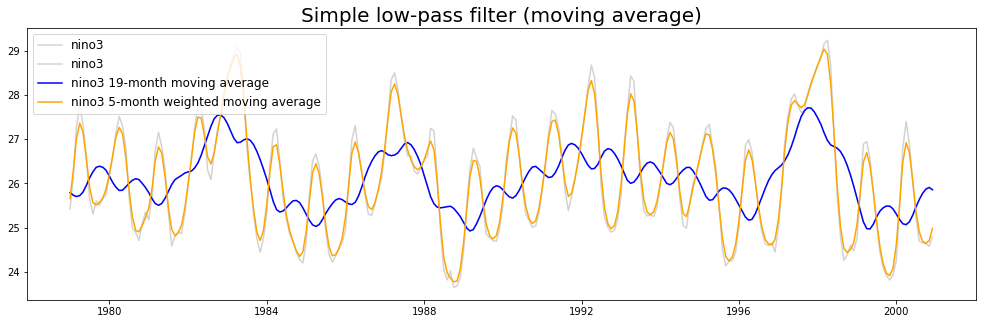

In [13]:
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(17,5))

ax.plot(nino3.sel(time=slice('1979-01-01', '2000-12-01')).time, nino3.sel(time=slice('1979-01-01', '2000-12-01')), 
        color = 'lightgray', label = 'nino3')
ax.plot(nino3.sel(time=slice('1979-01-01', '2000-12-01')).time, nino3_19mo_ma2.sel(time=slice('1979-01-01', '2000-12-01')), 
        color = 'lightgray', label = 'nino3')

ax.plot(nino3.sel(time=slice('1979-01-01', '2000-12-01')).time, nino3_19mo_ma_slice, 
        color = 'blue', label = 'nino3 19-month moving average')
ax.plot(nino3.sel(time=slice('1979-01-01', '2000-12-01')).time, wma_5mo_slice, 
        color = 'orange', label = 'nino3 5-month weighted moving average')
#얘네 둘은 time dimension이 없어서 아예 data처리 단계에서
#해당 기간에 해당하는 data값들만 index를 직접 지정해서 slicing을 했음. 

ax.legend(fontsize='large',loc='upper left')
ax.set_title('Simple low-pass filter (moving average)', fontsize=20)
plt.show()

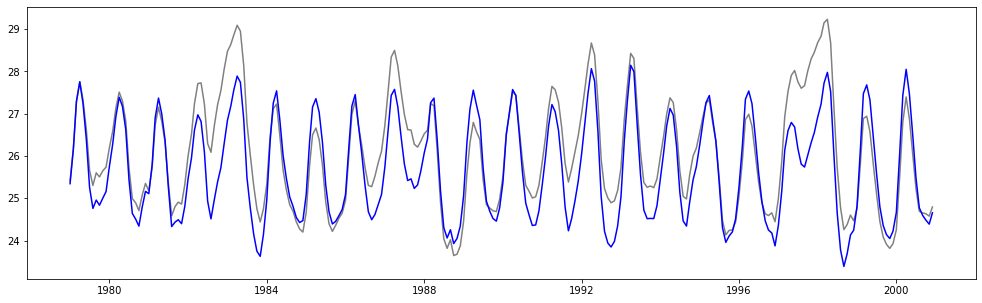

In [14]:
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(17,5))

ax.plot(nino3.sel(time=slice('1979-01-01', '2000-12-01')).time, nino3.sel(time=slice('1979-01-01', '2000-12-01')), 
        color = 'gray', label = 'nino3')
ax.plot(nino3.sel(time=slice('1979-01-01', '2000-12-01')).time, nino3_remove_ma.sel(time=slice('1979-01-01', '2000-12-01')), 
        color = 'blue', label = 'nino3')
